# Этап 1. Fine-tuning CLIP

In [1]:
DATA_PATH = "archive"

## 1. Работа с данными

### Выгрузка и первичный анализ данных

Размер датасета: 44441 записей

Первые строки:
       image                                        description  \
0   3238.jpg  Round toed, black sports shoes with red accent...   
1  43044.jpg  Style Note Built with the breathability and ze...   
2  54018.jpg  Teal  handbag that has stitch detailing with a...   
3   8141.jpg  Perfectly stylish, this fastrack analog wrist ...   
4  22245.jpg  These id mid-top chukka shoes add a fresh spin...   

                                        display name      category  
0         Puma Men Black 65CC Lo Ducati Sports Shoes  Sports Shoes  
1                      Nike Men Charcoal Grey Shorts        Shorts  
2                           Kiara Women Teal Handbag      Handbags  
3  Fastrack Women Freestyle Sports Analog Steel B...       Watches  
4                          ID Men Brown Casual Shoes  Casual Shoes  

Изображение: 33277.jpg
Разрешение: (1080, 1440)
Описание: Composition Blue washed denim jeans made of 100% cotton, has two insert pocke

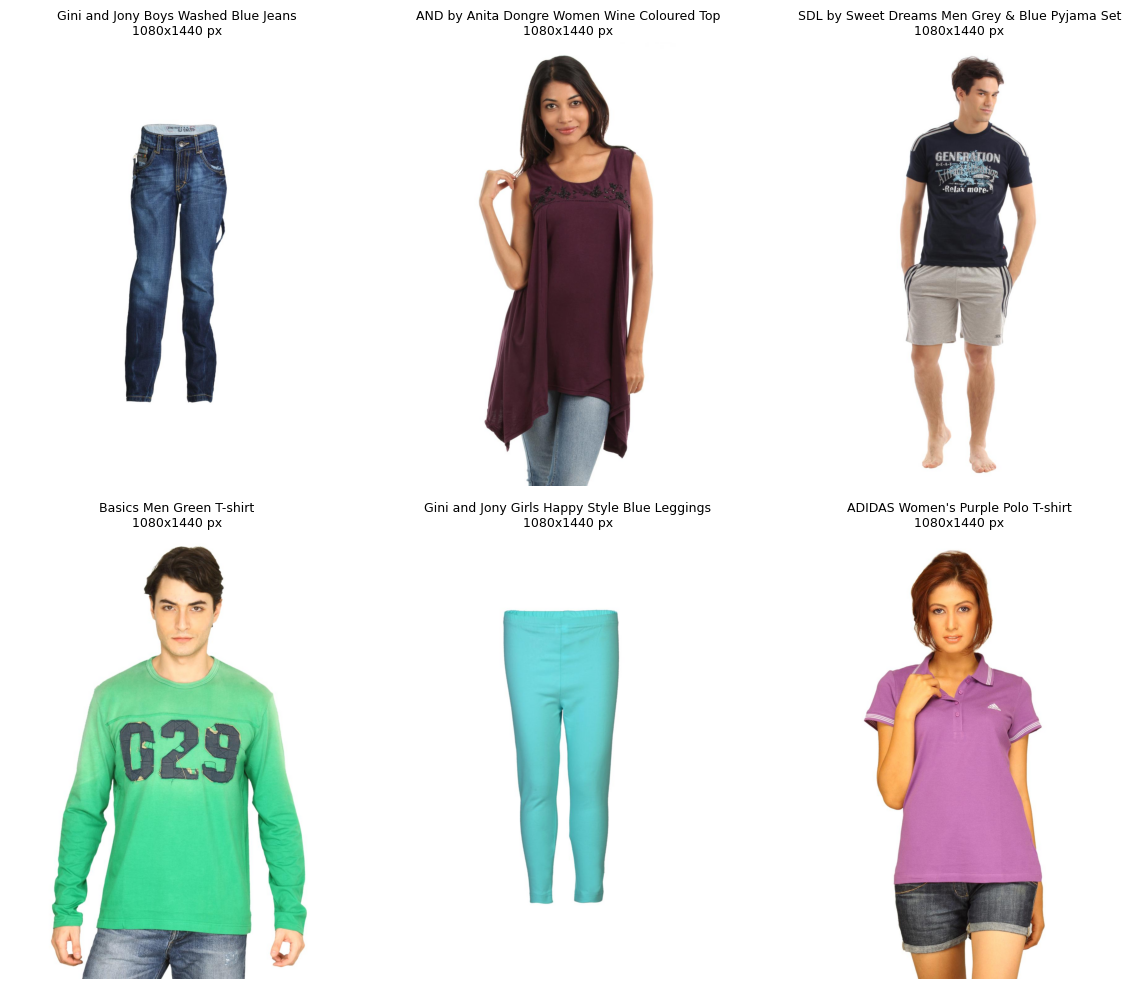

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os


df = pd.read_csv(f'{DATA_PATH}/data.csv')
print(f'Размер датасета: {len(df)} записей')
print()
print('Первые строки:')
print(df.head())

samples = df.sample(6, random_state=42)

fig, axes = plt.subplots(2, 3, figsize=(12, 10))
axes = axes.flatten()

for idx, (_, row) in enumerate(samples.iterrows()):
    img_path = os.path.join(f'{DATA_PATH}/data', row['image'])
    img = Image.open(img_path)
    
    axes[idx].imshow(img)
    axes[idx].set_title(f"{row['display name']}\n{img.size[0]}x{img.size[1]} px", fontsize=9)
    axes[idx].axis('off')
    print()
    print(f"Изображение: {row['image']}")
    print(f"Разрешение: {img.size}")
    print(f"Описание: {row['description'][:150]}")

plt.tight_layout()
plt.show()

Вроде все корректно.

### Проверка распределения разрешений

In [3]:
from PIL import Image
import os

resolutions = set()

for img_name in df['image']:
    img_path = os.path.join(DATA_PATH, 'data', img_name)
    with Image.open(img_path) as img:
        resolutions.add(img.size)

print(f'Уникальных разрешений: {len(resolutions)}')
print(resolutions)

Уникальных разрешений: 1
{(1080, 1440)}


### Проверка дубликатов и пустых данных

In [4]:
print(df.info())
print(f'\nРазмер датасета: {df.shape}')

print(f'\nПропуски')
print(df.isnull().sum())

print(f'\nДубликаты')
print(f'Полных дубликатов строк: {df.duplicated().sum()}')
print(f'Дубликатов по изображению: {df["image"].duplicated().sum()}')
print(f'Дубликатов по описанию: {df["description"].duplicated().sum()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44441 entries, 0 to 44440
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   image         44441 non-null  object
 1   description   44160 non-null  object
 2   display name  44434 non-null  object
 3   category      44441 non-null  object
dtypes: object(4)
memory usage: 1.4+ MB
None

Размер датасета: (44441, 4)

Пропуски
image             0
description     281
display name      7
category          0
dtype: int64

Дубликаты
Полных дубликатов строк: 0
Дубликатов по изображению: 0
Дубликатов по описанию: 5584


### Удаление дубликатов и пустых данных

In [5]:
print(f'До очистки: {df.shape}')
df = df.drop_duplicates(subset=['description'])
df = df.dropna()
print(f'После очистки: {df.shape}')

До очистки: (44441, 4)
После очистки: (38856, 4)


### Разделение ланных на обучающую и валидационную выборки (90/10)

In [6]:
from sklearn.model_selection import train_test_split


train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)
print(f'Train: {len(train_df)}, Test: {len(test_df)}')

Train: 34970, Test: 3886


### Класс датасета

In [7]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os


class ProductDataset(Dataset):
    def __init__(self, df, img_dir, transform=None, tokenizer=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['image'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        text = row['description']
        if self.tokenizer:
            text = self.tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=77)
        return image, text


dataset = ProductDataset(df, img_dir=f'{DATA_PATH}/data')
img, text = dataset[0]
print('Тип изображения:', type(img))
print('Тип текста:', type(text))
print('Текст:', text if isinstance(text, str) else text['input_ids'])

Тип изображения: <class 'PIL.Image.Image'>
Тип текста: <class 'str'>
Текст: Round toed, black sports shoes with red accents, low top styling and central lace-ups Leather upper with stitched detail, overlay, Formstrip and Ducati branding on the sides and reinforced heel collar with branding Soft tongue and inner, branding on the tongue Cushioned footbed with branding at the heel Printed detail at the midsole Textured rubber outsole with patterned grooves and branding Warranty: 3 months against manufacturing defects only


## 2. Работа с моделью

c:\Users\pasha\practicum_yandex_train_clip\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Index: 2277, CLIP score: 30.51
Text: Composition Red round neck tunic top made of 65% polyester and 35% viscose, rouched dolman sleeves a



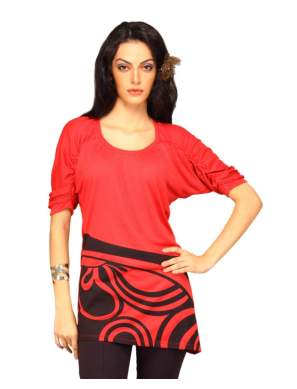

Index: 3010, CLIP score: 27.87
Text: Lakmé    Absolute Fast &    Fabulous Nail Color sets in just 40 seconds Comes with a unique brush wh



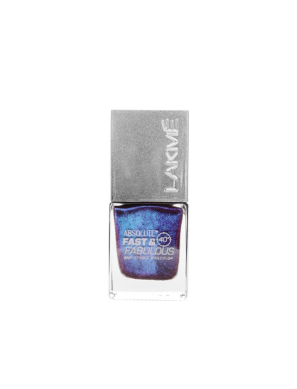

Index: 15574, CLIP score: 26.33
Text: Specialising in fashionable style, and crafted by skilled Indian craftsmen, murcia bags use the fine



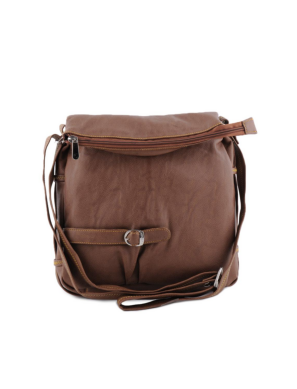

Index: 31771, CLIP score: 31.82
Text: Talk about style and space rolled into one, and there's no better bag for a Sports fan. Neatly desig



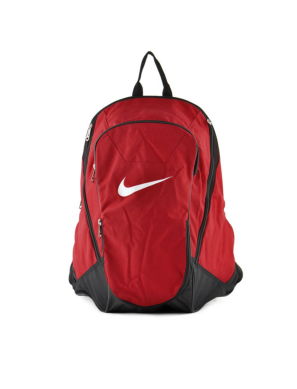

Index: 22676, CLIP score: 31.33
Text: Style Note Understated and stylish, this simplistically designed shirt from french connection is jus



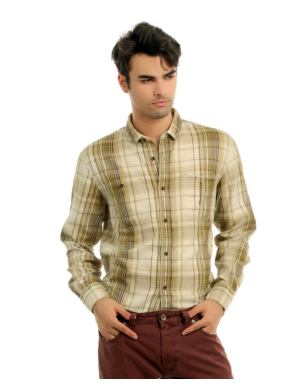

Index: 11940, CLIP score: 29.97
Text: Composition Green and white check shirt, made of 100% cotton, has full sleeves with buttoned cuffs, 



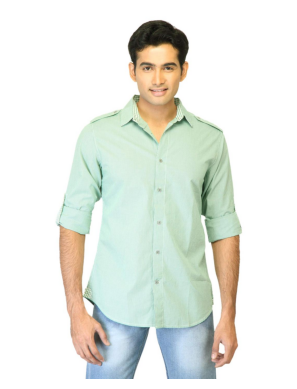

Index: 26925, CLIP score: 27.85
Text: Case style: Stainless steel round case for enhanced durability, double ring, blue crystal encrusted,



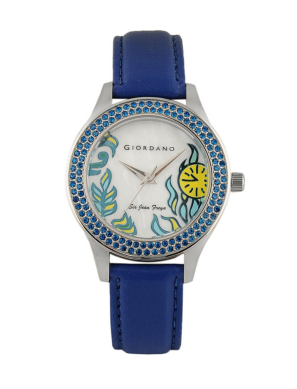

Index: 35154, CLIP score: 32.73
Text: Brown round toed high-top shoes with central lace-ups Mild padding at the inner Tough sole with a st



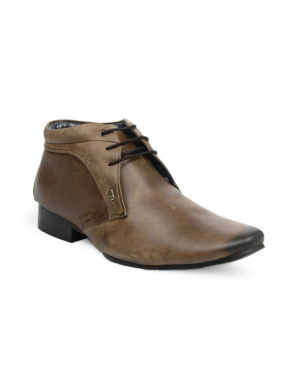

Index: 36959, CLIP score: 32.44
Text: Black briefs that has a broad, elasticated silver coloured waistband, stitch detailing, printed bran



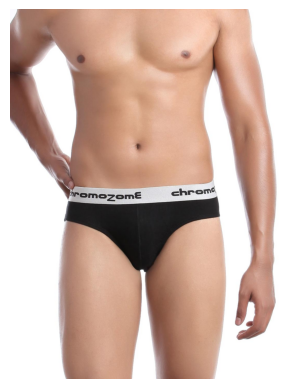

Index: 34879, CLIP score: 28.87
Text: vans brings you footwear for the urban youth. Inspired by skate boarders, the Bedford shoes come in 



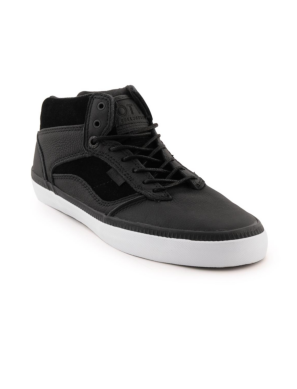

In [8]:
from transformers import CLIPProcessor, CLIPModel
import numpy as np
import matplotlib.pyplot as plt


model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

clip_dataset = ProductDataset(df, img_dir=f'{DATA_PATH}/data')

n_samples = 10
sample_idx = np.random.choice(len(clip_dataset), n_samples, replace=False)

for idx in sample_idx:
    image, text = clip_dataset[idx]
    inputs = processor(text=[text], images=image, return_tensors="pt", padding=True, truncation=True)
    
    with torch.no_grad():
        outputs = model(**inputs)
        logits_per_image = outputs.logits_per_image
        score = logits_per_image.item()
    
    print(f"Index: {int(idx)}, CLIP score: {score:.2f}")
    print(f"Text: {text[:100]}\n")
    plt.imshow(image)
    plt.axis('off')
    plt.show()

Прогон нескольких случайных примеров через модель CLIP показал, что значения CLIP score находятся в диапазоне 28–32, что говорит о хорошем соответствии между изображениями и текстовыми описаниями. Во всех рассмотренных примерах текст в целом правильно описывает содержимое изображения.

## 3. Дообучение

In [9]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from transformers import CLIPModel, CLIPProcessor
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


BATCH_SIZE = 32
LR = 1e-4
NUM_EPOCHS = 10
LOG_DIR = "runs/clip_experiment"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def clip_collate_fn(batch):
    images, texts = zip(*batch)
    return list(images), list(texts)


model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name).to(device)
processor = CLIPProcessor.from_pretrained(model_name)


train_dataset = ProductDataset(train_df, img_dir=f"{DATA_PATH}/data")
test_dataset  = ProductDataset(test_df,  img_dir=f"{DATA_PATH}/data")

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=clip_collate_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=clip_collate_fn
)

for param in model.parameters():
    param.requires_grad = False

for param in model.visual_projection.parameters():
    param.requires_grad = True

for param in model.text_projection.parameters():
    param.requires_grad = True

model.logit_scale.requires_grad = True

optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LR
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=NUM_EPOCHS
)

def clip_loss(logits_per_image, logits_per_text):
    batch_size = logits_per_image.size(0)
    labels = torch.arange(batch_size).to(logits_per_image.device)
    loss_i = F.cross_entropy(logits_per_image, labels)
    loss_t = F.cross_entropy(logits_per_text, labels)
    return (loss_i + loss_t) / 2

def compute_clip_score(logits_per_image):
    return logits_per_image.diagonal().mean().item()

def validate(model, dataloader):
    model.eval()
    total_score = 0

    with torch.no_grad():
        for images, texts in tqdm(dataloader, desc="Validation", leave=False):
            inputs = processor(
                images=images,
                text=texts,
                return_tensors="pt",
                padding=True,
                truncation=True
            )
            inputs = {k: v.to(device) for k, v in inputs.items()}

            outputs = model(**inputs)
            total_score += compute_clip_score(outputs.logits_per_image)

    return total_score / len(dataloader)

In [10]:
baseline_score = validate(model, test_loader)
print(f"Baseline CLIP score (no finetuning): {baseline_score:.2f}")

Baseline CLIP score (no finetuning): 30.37


Предобученная модель CLIP показала baseline CLIP score выше 30 на тестовой выборке. Далее было выполнено дообучение модели с целью возможного улучшения метрики и адаптации под домен датасета.

In [11]:
writer = SummaryWriter(log_dir=LOG_DIR)

best_val_score = -float("inf")
train_losses, train_scores, val_scores = [], [], []

global_step = 0
for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0
    epoch_score = 0
    
    for batch_idx, (images, texts) in enumerate(train_loader):
        inputs = processor(
            images=images,
            text=texts,
            return_tensors="pt",
            padding=True,
            truncation=True
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        outputs = model(**inputs)
        loss = clip_loss(outputs.logits_per_image, outputs.logits_per_text)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        score = compute_clip_score(outputs.logits_per_image)

        epoch_loss += loss.item()
        epoch_score += score

        writer.add_scalar("Train/Loss_batch", loss.item(), global_step)
        writer.add_scalar("Train/CLIP_score_batch", score, global_step)
        global_step += 1

        print(
            f"Epoch [{epoch+1}/{NUM_EPOCHS}] "
            f"Batch [{batch_idx+1}/{len(train_loader)}] "
            f"Loss: {loss.item():.4f} "
            f"CLIP score: {score:.2f}"
        )

    avg_loss = epoch_loss / len(train_loader)
    avg_score = epoch_score / len(train_loader)
    val_score = validate(model, test_loader)

    train_losses.append(avg_loss)
    train_scores.append(avg_score)
    val_scores.append(val_score)

    writer.add_scalar("Train/Loss_epoch", avg_loss, epoch + 1)
    writer.add_scalar("Train/CLIP_score_epoch", avg_score, epoch + 1)
    writer.add_scalar("Val/CLIP_score_epoch", val_score, epoch + 1)

    print(
        f"\nEpoch {epoch+1} summary:"
        f"\nTrain loss: {avg_loss:.4f}"
        f"\nTrain CLIP score: {avg_score:.2f}"
        f"\nVal CLIP score: {val_score:.2f}\n"
    )

    if val_score > best_val_score:
        best_val_score = val_score
        torch.save(model.state_dict(), "clip_best.pth")

    torch.save(model.state_dict(), f"clip_epoch_{epoch+1}.pth")
    scheduler.step()

writer.close()

Epoch [1/10] Batch [1/1093] Loss: 0.6490 CLIP score: 30.51
Epoch [1/10] Batch [2/1093] Loss: 0.6085 CLIP score: 30.40
Epoch [1/10] Batch [3/1093] Loss: 0.4744 CLIP score: 30.30
Epoch [1/10] Batch [4/1093] Loss: 0.7276 CLIP score: 31.41
Epoch [1/10] Batch [5/1093] Loss: 0.6686 CLIP score: 31.41
Epoch [1/10] Batch [6/1093] Loss: 0.5201 CLIP score: 31.62
Epoch [1/10] Batch [7/1093] Loss: 0.5563 CLIP score: 31.66
Epoch [1/10] Batch [8/1093] Loss: 0.5507 CLIP score: 30.46
Epoch [1/10] Batch [9/1093] Loss: 0.5289 CLIP score: 29.90
Epoch [1/10] Batch [10/1093] Loss: 0.4632 CLIP score: 28.89
Epoch [1/10] Batch [11/1093] Loss: 1.0692 CLIP score: 29.37
Epoch [1/10] Batch [12/1093] Loss: 0.5907 CLIP score: 28.16
Epoch [1/10] Batch [13/1093] Loss: 0.2471 CLIP score: 29.28
Epoch [1/10] Batch [14/1093] Loss: 0.5254 CLIP score: 28.06
Epoch [1/10] Batch [15/1093] Loss: 0.5633 CLIP score: 28.18
Epoch [1/10] Batch [16/1093] Loss: 0.5335 CLIP score: 27.73
Epoch [1/10] Batch [17/1093] Loss: 0.7493 CLIP sc


Epoch 1 summary:
Train loss: 0.3687
Train CLIP score: 27.12
Val CLIP score: 27.57

Epoch [2/10] Batch [1/1093] Loss: 0.3732 CLIP score: 26.92
Epoch [2/10] Batch [2/1093] Loss: 0.1854 CLIP score: 28.00
Epoch [2/10] Batch [3/1093] Loss: 0.2662 CLIP score: 27.90
Epoch [2/10] Batch [4/1093] Loss: 0.1684 CLIP score: 27.89
Epoch [2/10] Batch [5/1093] Loss: 0.3198 CLIP score: 27.93
Epoch [2/10] Batch [6/1093] Loss: 0.1110 CLIP score: 27.77
Epoch [2/10] Batch [7/1093] Loss: 0.3904 CLIP score: 27.39
Epoch [2/10] Batch [8/1093] Loss: 0.2162 CLIP score: 27.81
Epoch [2/10] Batch [9/1093] Loss: 0.1816 CLIP score: 27.55
Epoch [2/10] Batch [10/1093] Loss: 0.3334 CLIP score: 28.06
Epoch [2/10] Batch [11/1093] Loss: 0.3029 CLIP score: 27.83
Epoch [2/10] Batch [12/1093] Loss: 0.2329 CLIP score: 27.97
Epoch [2/10] Batch [13/1093] Loss: 0.3696 CLIP score: 27.70
Epoch [2/10] Batch [14/1093] Loss: 0.1864 CLIP score: 28.08
Epoch [2/10] Batch [15/1093] Loss: 0.4300 CLIP score: 27.33
Epoch [2/10] Batch [16/10


Epoch 2 summary:
Train loss: 0.2567
Train CLIP score: 29.10
Val CLIP score: 29.12

Epoch [3/10] Batch [1/1093] Loss: 0.0908 CLIP score: 29.69
Epoch [3/10] Batch [2/1093] Loss: 0.2022 CLIP score: 29.41
Epoch [3/10] Batch [3/1093] Loss: 0.0609 CLIP score: 29.96
Epoch [3/10] Batch [4/1093] Loss: 0.1382 CLIP score: 29.78
Epoch [3/10] Batch [5/1093] Loss: 0.5430 CLIP score: 29.32
Epoch [3/10] Batch [6/1093] Loss: 0.0766 CLIP score: 29.75
Epoch [3/10] Batch [7/1093] Loss: 0.3480 CLIP score: 28.62
Epoch [3/10] Batch [8/1093] Loss: 0.1169 CLIP score: 29.40
Epoch [3/10] Batch [9/1093] Loss: 0.1528 CLIP score: 29.94
Epoch [3/10] Batch [10/1093] Loss: 0.2011 CLIP score: 29.77
Epoch [3/10] Batch [11/1093] Loss: 0.2628 CLIP score: 29.47
Epoch [3/10] Batch [12/1093] Loss: 0.3718 CLIP score: 28.98
Epoch [3/10] Batch [13/1093] Loss: 0.3659 CLIP score: 28.43
Epoch [3/10] Batch [14/1093] Loss: 0.2571 CLIP score: 29.34
Epoch [3/10] Batch [15/1093] Loss: 0.1108 CLIP score: 29.44
Epoch [3/10] Batch [16/10


Epoch 3 summary:
Train loss: 0.2138
Train CLIP score: 30.77
Val CLIP score: 30.55

Epoch [4/10] Batch [1/1093] Loss: 0.1020 CLIP score: 30.88
Epoch [4/10] Batch [2/1093] Loss: 0.1203 CLIP score: 30.82
Epoch [4/10] Batch [3/1093] Loss: 0.1923 CLIP score: 30.86
Epoch [4/10] Batch [4/1093] Loss: 0.1742 CLIP score: 31.47
Epoch [4/10] Batch [5/1093] Loss: 0.1993 CLIP score: 31.25
Epoch [4/10] Batch [6/1093] Loss: 0.0720 CLIP score: 30.92
Epoch [4/10] Batch [7/1093] Loss: 0.2011 CLIP score: 31.37
Epoch [4/10] Batch [8/1093] Loss: 0.1098 CLIP score: 31.49
Epoch [4/10] Batch [9/1093] Loss: 0.1721 CLIP score: 31.15
Epoch [4/10] Batch [10/1093] Loss: 0.0892 CLIP score: 32.21
Epoch [4/10] Batch [11/1093] Loss: 0.1364 CLIP score: 31.42
Epoch [4/10] Batch [12/1093] Loss: 0.2979 CLIP score: 30.99
Epoch [4/10] Batch [13/1093] Loss: 0.1196 CLIP score: 32.16
Epoch [4/10] Batch [14/1093] Loss: 0.1809 CLIP score: 30.42
Epoch [4/10] Batch [15/1093] Loss: 0.1622 CLIP score: 31.15
Epoch [4/10] Batch [16/10


Epoch 4 summary:
Train loss: 0.1828
Train CLIP score: 31.46
Val CLIP score: 30.71

Epoch [5/10] Batch [1/1093] Loss: 0.1954 CLIP score: 30.88
Epoch [5/10] Batch [2/1093] Loss: 0.0617 CLIP score: 31.01
Epoch [5/10] Batch [3/1093] Loss: 0.2194 CLIP score: 31.36
Epoch [5/10] Batch [4/1093] Loss: 0.1426 CLIP score: 30.85
Epoch [5/10] Batch [5/1093] Loss: 0.3426 CLIP score: 30.21
Epoch [5/10] Batch [6/1093] Loss: 0.1757 CLIP score: 30.41
Epoch [5/10] Batch [7/1093] Loss: 0.1193 CLIP score: 31.29
Epoch [5/10] Batch [8/1093] Loss: 0.1352 CLIP score: 31.66
Epoch [5/10] Batch [9/1093] Loss: 0.1065 CLIP score: 30.76
Epoch [5/10] Batch [10/1093] Loss: 0.2658 CLIP score: 30.80
Epoch [5/10] Batch [11/1093] Loss: 0.2073 CLIP score: 31.52
Epoch [5/10] Batch [12/1093] Loss: 0.0623 CLIP score: 31.01
Epoch [5/10] Batch [13/1093] Loss: 0.0793 CLIP score: 31.88
Epoch [5/10] Batch [14/1093] Loss: 0.1467 CLIP score: 31.44
Epoch [5/10] Batch [15/1093] Loss: 0.3171 CLIP score: 30.72
Epoch [5/10] Batch [16/10


Epoch 5 summary:
Train loss: 0.1567
Train CLIP score: 32.40
Val CLIP score: 30.94

Epoch [6/10] Batch [1/1093] Loss: 0.0546 CLIP score: 31.97
Epoch [6/10] Batch [2/1093] Loss: 0.1690 CLIP score: 30.73
Epoch [6/10] Batch [3/1093] Loss: 0.1936 CLIP score: 30.89
Epoch [6/10] Batch [4/1093] Loss: 0.1294 CLIP score: 30.67
Epoch [6/10] Batch [5/1093] Loss: 0.0734 CLIP score: 32.34
Epoch [6/10] Batch [6/1093] Loss: 0.0745 CLIP score: 31.12
Epoch [6/10] Batch [7/1093] Loss: 0.0779 CLIP score: 31.27
Epoch [6/10] Batch [8/1093] Loss: 0.0854 CLIP score: 31.36
Epoch [6/10] Batch [9/1093] Loss: 0.1547 CLIP score: 31.33
Epoch [6/10] Batch [10/1093] Loss: 0.2119 CLIP score: 31.12
Epoch [6/10] Batch [11/1093] Loss: 0.1080 CLIP score: 31.43
Epoch [6/10] Batch [12/1093] Loss: 0.2213 CLIP score: 31.53
Epoch [6/10] Batch [13/1093] Loss: 0.1683 CLIP score: 30.98
Epoch [6/10] Batch [14/1093] Loss: 0.2006 CLIP score: 31.82
Epoch [6/10] Batch [15/1093] Loss: 0.1315 CLIP score: 32.03
Epoch [6/10] Batch [16/10


Epoch 6 summary:
Train loss: 0.1355
Train CLIP score: 33.01
Val CLIP score: 33.78

Epoch [7/10] Batch [1/1093] Loss: 0.0430 CLIP score: 34.36
Epoch [7/10] Batch [2/1093] Loss: 0.0854 CLIP score: 34.80
Epoch [7/10] Batch [3/1093] Loss: 0.1243 CLIP score: 34.64
Epoch [7/10] Batch [4/1093] Loss: 0.1096 CLIP score: 33.80
Epoch [7/10] Batch [5/1093] Loss: 0.1587 CLIP score: 34.15
Epoch [7/10] Batch [6/1093] Loss: 0.1826 CLIP score: 33.87
Epoch [7/10] Batch [7/1093] Loss: 0.0375 CLIP score: 34.46
Epoch [7/10] Batch [8/1093] Loss: 0.1238 CLIP score: 33.96
Epoch [7/10] Batch [9/1093] Loss: 0.2037 CLIP score: 34.29
Epoch [7/10] Batch [10/1093] Loss: 0.1320 CLIP score: 35.06
Epoch [7/10] Batch [11/1093] Loss: 0.0526 CLIP score: 35.34
Epoch [7/10] Batch [12/1093] Loss: 0.1850 CLIP score: 34.49
Epoch [7/10] Batch [13/1093] Loss: 0.1872 CLIP score: 34.18
Epoch [7/10] Batch [14/1093] Loss: 0.1447 CLIP score: 34.44
Epoch [7/10] Batch [15/1093] Loss: 0.1361 CLIP score: 34.87
Epoch [7/10] Batch [16/10


Epoch 7 summary:
Train loss: 0.1164
Train CLIP score: 34.08
Val CLIP score: 33.44

Epoch [8/10] Batch [1/1093] Loss: 0.0480 CLIP score: 34.23
Epoch [8/10] Batch [2/1093] Loss: 0.0523 CLIP score: 34.38
Epoch [8/10] Batch [3/1093] Loss: 0.0312 CLIP score: 34.59
Epoch [8/10] Batch [4/1093] Loss: 0.2436 CLIP score: 34.19
Epoch [8/10] Batch [5/1093] Loss: 0.2497 CLIP score: 34.31
Epoch [8/10] Batch [6/1093] Loss: 0.0930 CLIP score: 34.86
Epoch [8/10] Batch [7/1093] Loss: 0.1571 CLIP score: 33.72
Epoch [8/10] Batch [8/1093] Loss: 0.1041 CLIP score: 33.98
Epoch [8/10] Batch [9/1093] Loss: 0.1923 CLIP score: 33.93
Epoch [8/10] Batch [10/1093] Loss: 0.1715 CLIP score: 34.59
Epoch [8/10] Batch [11/1093] Loss: 0.1704 CLIP score: 33.76
Epoch [8/10] Batch [12/1093] Loss: 0.0827 CLIP score: 34.22
Epoch [8/10] Batch [13/1093] Loss: 0.1094 CLIP score: 34.14
Epoch [8/10] Batch [14/1093] Loss: 0.2365 CLIP score: 33.64
Epoch [8/10] Batch [15/1093] Loss: 0.0487 CLIP score: 34.31
Epoch [8/10] Batch [16/10


Epoch 8 summary:
Train loss: 0.1019
Train CLIP score: 34.51
Val CLIP score: 33.52

Epoch [9/10] Batch [1/1093] Loss: 0.0611 CLIP score: 34.35
Epoch [9/10] Batch [2/1093] Loss: 0.0524 CLIP score: 34.80
Epoch [9/10] Batch [3/1093] Loss: 0.1692 CLIP score: 34.20
Epoch [9/10] Batch [4/1093] Loss: 0.0878 CLIP score: 33.76
Epoch [9/10] Batch [5/1093] Loss: 0.1755 CLIP score: 34.04
Epoch [9/10] Batch [6/1093] Loss: 0.1218 CLIP score: 34.30
Epoch [9/10] Batch [7/1093] Loss: 0.0475 CLIP score: 33.11
Epoch [9/10] Batch [8/1093] Loss: 0.0854 CLIP score: 34.09
Epoch [9/10] Batch [9/1093] Loss: 0.2052 CLIP score: 34.32
Epoch [9/10] Batch [10/1093] Loss: 0.0096 CLIP score: 35.33
Epoch [9/10] Batch [11/1093] Loss: 0.0716 CLIP score: 34.51
Epoch [9/10] Batch [12/1093] Loss: 0.1289 CLIP score: 33.72
Epoch [9/10] Batch [13/1093] Loss: 0.0940 CLIP score: 34.47
Epoch [9/10] Batch [14/1093] Loss: 0.1610 CLIP score: 33.86
Epoch [9/10] Batch [15/1093] Loss: 0.0232 CLIP score: 35.68
Epoch [9/10] Batch [16/10


Epoch 9 summary:
Train loss: 0.0898
Train CLIP score: 34.89
Val CLIP score: 34.38

Epoch [10/10] Batch [1/1093] Loss: 0.1709 CLIP score: 35.43
Epoch [10/10] Batch [2/1093] Loss: 0.0348 CLIP score: 34.63
Epoch [10/10] Batch [3/1093] Loss: 0.2273 CLIP score: 34.67
Epoch [10/10] Batch [4/1093] Loss: 0.1340 CLIP score: 35.02
Epoch [10/10] Batch [5/1093] Loss: 0.0545 CLIP score: 35.62
Epoch [10/10] Batch [6/1093] Loss: 0.0194 CLIP score: 35.33
Epoch [10/10] Batch [7/1093] Loss: 0.1285 CLIP score: 34.16
Epoch [10/10] Batch [8/1093] Loss: 0.0619 CLIP score: 35.19
Epoch [10/10] Batch [9/1093] Loss: 0.0719 CLIP score: 35.33
Epoch [10/10] Batch [10/1093] Loss: 0.0324 CLIP score: 34.71
Epoch [10/10] Batch [11/1093] Loss: 0.0490 CLIP score: 35.56
Epoch [10/10] Batch [12/1093] Loss: 0.0405 CLIP score: 34.74
Epoch [10/10] Batch [13/1093] Loss: 0.1446 CLIP score: 35.37
Epoch [10/10] Batch [14/1093] Loss: 0.1420 CLIP score: 35.03
Epoch [10/10] Batch [15/1093] Loss: 0.0046 CLIP score: 35.12
Epoch [10/


Epoch 10 summary:
Train loss: 0.0877
Train CLIP score: 35.16
Val CLIP score: 34.42



In [12]:
best_ckpt = "clip_best.pth"
model.load_state_dict(torch.load(best_ckpt, map_location=device))
model.to(device)
model.eval()
finetuning_score = validate(model, test_loader)
print(f"Baseline CLIP score (finetuning): {finetuning_score:.2f}")

Baseline CLIP score (finetuning): 34.42


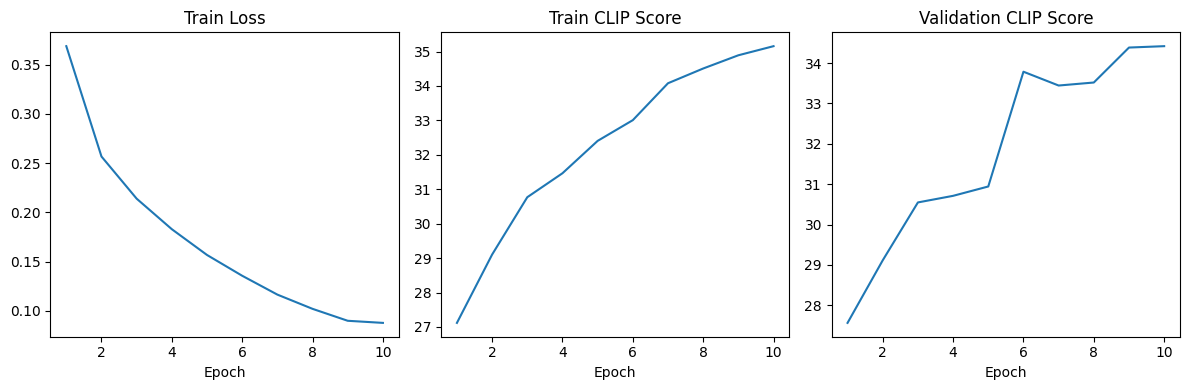

In [13]:
epochs = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses)
plt.title("Train Loss")
plt.xlabel("Epoch")

plt.subplot(1, 3, 2)
plt.plot(epochs, train_scores)
plt.title("Train CLIP Score")
plt.xlabel("Epoch")

plt.subplot(1, 3, 3)
plt.plot(epochs, val_scores)
plt.title("Validation CLIP Score")
plt.xlabel("Epoch")

plt.tight_layout()
plt.show()

В результате дообучения модели CLIP средний CLIP score на валидационной выборке увеличился с 30.37 до 34.42, что соответствует росту примерно на 13%. При этом наблюдается потенциал для дальнейшего улучшения метрики при продолжении обучения или дополнительной настройке гиперпараметров, однако полученного качества уже достаточно для решения поставленной задачи.

# Этап 2. Реализация системы поиска товаров

## 1. Работа с данными

Возьмите весь датасет целиком. Чтобы система поиска товаров работала быстро, нужно заранее посчитать векторные представления всех картинок. Загрузите чекпоинт дообученной модели и сохраните все векторные представления изображений.

## 2. Функция поиска товаров

Напишите функцию поиска товаров.
Функция должна принимать такие аргументы: 
модель,
данные из всего датасета,
текстовый запрос пользователя,
количество наиболее релевантных товаров, которые будут показываться пользователю. 
Формат аргументов выберите самостоятельно. Если нужно, передавайте в функцию дополнительные аргументы. 
Функция должна вычислять векторное представление текстового запроса пользователя, находить заданное количество наиболее актуальных картинок с товарами и возвращать их.

## 3. Тестирование функции поиска товаров 

Протестируйте написанную функцию. Введите несколько запросов, например: "red skirt", "blue sunglasses", "mickey mouse". Отрисуйте изображения товаров, которые выводит функция.

Результат: реализована поисковая система, способная принимать текстовые запросы и возвращать наиболее релевантные изображения из датасета. Система должна работать эффективно, то есть не пересчитывать каждый раз векторные представления картинок.